<font size="5">Run the ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- initiate the model with elevation, friction, stage
- set the boundary conditions
- run the model!



</font>

<font size="3">Before you can run this notebook, you should have run the 4_Build_ANUGA_Mesh</font>


<font size=5 color='green'> If you are running in Google Colab, set the variable yes_colab = True. If you are running on your own computer, set the variable yes_colab = False </font>


In [ ]:
yes_colab = True

<font size=5> Step #1: Mount Google Drive and Grant Access <font> <br>




<font size=3> When you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>


In [ ]:
import sys
import os
your_path = os.getcwd() + '/'
if yes_colab:
  where_to_mount = '/content/drive/'
  from google.colab import drive
  drive.mount(where_to_mount, force_remount=True)
  mounted_drive = where_to_mount + 'MyDrive/' 
else:
  mounted_drive = your_path



Mounted at /content/drive/


<font size=5> Step #2: Install packages. <font> <br>
<font size=3> This cell should install all Python packages you need for each tutorial.<font>

In [ ]:
import os
os.chdir(mounted_drive)
if yes_colab:
  if os.path.isdir(mounted_drive + 'komo_estuary_tutorial'):
    print('## Updating the local git repository \n')
    os.chdir(mounted_drive + '/komo_estuary_tutorial')
    ! git pull 
  else:
    print('## Pulling the git repository with files for the tutorial\n')
    ! git clone https://github.com/achri19/komo_estuary_tutorial.git

  print('\n## Installing the Python packages needed for these tutorials\n')
  !/bin/bash $mounted_drive/komo_estuary_tutorial/install_packages.sh




## Updating the local git repository 

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/achri19/komo_estuary_tutorial
   b46e595..540ceee  main       -> origin/main
Updating b46e595..540ceee
Fast-forward
 2_Setup_DEM.ipynb | 816 +++++++++---------------------------------------------
 1 file changed, 126 insertions(+), 690 deletions(-)

## Installing the Python packages needed for these tutorials

(1) Install pip packages to /content/drive/MyDrive/installations
nose mpi4py triangle Pmw pymetis cmocean geopandas fiona pygeos rasterio rasterstats scikit-fmm rtree pyTMD Orinoco
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
https://github.com/GeoscienceAustralia/anuga_core
(5) Install anuga
(7) Completed


In [ ]:
!unzip -n komo_estuary_tutorial/komo_starter.zip -d $mounted_drive 


Archive:  komo_starter.zip


<font size=5> Step #3: Set up working directories<font> 


<font size=3> We will access data files stored on a shared Google Drive. You will also need to save files to your own Google Drive.<font>



In [ ]:
path_code = mounted_drive + 'processing/code/'
path_templates = mounted_drive + 'processing/templates/'
path_configs = mounted_drive + 'processing/configs/'
path_ancillary = mounted_drive + 'processing/ancillary/'
sys.path.insert(1,path_code)


<font size=5> Step #4: Now we will import Python packages, which will be used for future tutorials. If there are any errors, try rerunning the first cell <font> 




In [ ]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 

import matplotlib.pyplot as plt

import anuga
import ee 
import geemap
from pathlib import Path

from anuga.utilities.plot_utils import Make_Geotif


In [ ]:
from BYOM_extra import (make_segments_for_swot)
from BYOM_Utilities_V1 import (make_watermask, build_directory)


/content/drive/MyDrive/processing/code/BYOM_extra.py:15: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/content/drive/MyDrive/processing/code/BYOM_extra.py:16: UserWarning: UserWarning
  warnings.warn('UserWarning')
/content/drive/MyDrive/processing/code/raster_bridges.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/content/drive/MyDrive/processing/code/raster_bridges.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')
/content/drive/MyDrive/processing/code/use_orinoco.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/content/drive/MyDrive/processing/code/use_orinoco.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')


In [ ]:
AOI = 'komo'

res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(mounted_drive, AOI)

modelpath = '/content/drive/MyDrive/komo/Simulations/komo_300cms_20210101_Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1_Meshes_base_100000m2_BrBout'
scenario = modelpath.split('/')[-1]
print(scenario)
mesh_path = folders[3] + '_'.join(scenario.split('_')[-4:-1])
print(mesh_path)




Study area is komo
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/content/drive/MyDrive/komo/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
##################### 8 Setup_F

In [ ]:
parameters = pd.read_csv(folders[6] + '/config_%s.csv' %(AOI))


In [ ]:
## STEP 5
## Make river and ocean segments for SWOT simulator
## Approximately 900m for river segments and 10000m2 for oceans
ulx  = parameters['ulx'][0]                                                 # ULX coordinate
lry  = parameters['lry'][0]                                                 # LRY coordinate
lrx  = parameters['lrx'][0]                                                 # LRX coordinate
uly  = parameters['uly'][0]                                                 # ULY coordinate
EPSG = int(parameters['EPSG'][0])

dem = rasterio.open(folders[4] + '/' + 'Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1m_30.tif')


In [ ]:
extentfile = gpd.read_file('%s%s_input.shp' %(folders[0],AOI))
extentfile.crs = 'EPSG:4326'

Path('%s/outputRST/stage'%(modelpath)).mkdir(parents=True, exist_ok=True)


print('Extract bed elevation from SWW file')
print('Resampled to %s m resolution' %(res))
Make_Geotif(swwFile=modelpath +'/'+ scenario + '.sww',
          output_quantities=['elevation'],
          myTimeStep=0,
          CellSize=res,
          lower_left=None, upper_right=None,
          EPSG_CODE=EPSG,
          proj4string=None,
          velocity_extrapolation=True,
          min_allowed_height=1.0e-05,
          output_dir=modelpath + '/outputRST/',
          k_nearest_neighbours=1,
          bounding_polygon=anuga.read_polygon('%s/%s_domain_points.csv' %(mesh_path,AOI)),
          verbose=True,creation_options=['COMPRESS=DEFLATE'])

print('\nExtract time series of stage from SWW file')
Make_Geotif(swwFile='%s/%s.sww' %(modelpath,scenario),
          output_quantities=['stage'],
          myTimeStep=range(1,3,1),
          CellSize=res,
          lower_left=None, upper_right=None,
          EPSG_CODE=EPSG,
          proj4string=None,
          velocity_extrapolation=True,
          min_allowed_height=1.0e-05,
          output_dir=modelpath + '/outputRST/stage/',
          k_nearest_neighbours=1,
          bounding_polygon=anuga.read_polygon('%s/%s_domain_points.csv' %(mesh_path,AOI)),
          verbose=True,creation_options=['COMPRESS=DEFLATE'])

Extract bed elevation from SWW file
Resampled to 30 m resolution
Reading sww File ...
Extracting required data ...
Computing grid of output locations...
Making interpolation functions...
Reduction =  0
elevation
Making raster ...

Extract time series of stage from SWW file
Reading sww File ...
Extracting required data ...
Computing grid of output locations...
Making interpolation functions...
Reduction =  0
stage
Making raster ...
Reduction =  1
stage
Making raster ...


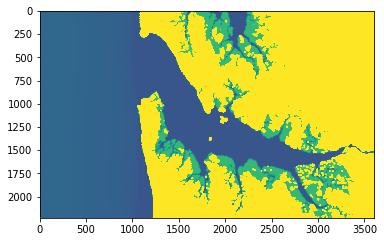

In [ ]:
stage1 = rasterio.open(modelpath + '/outputRST/stage/komo_300cms_20210101_Elevation_ocean-GEBCO_land-GLO30_above1260m-wdpower_below1260m-plane_wetland-uni05m_lakes-uni1_Meshes_base_100000m2_BrBout_stage_1_Time_1800.tif')

plt.imshow(stage1.read(1),vmin=-0.5,vmax=1)

You can download the full tutorial output here:
https://drive.google.com/file/d/1tRd_VjRimW9UyHSlV1Y-xBhiXX4lavQz/view?usp=share_link


In [ ]:
# os.chdir(mounted_drive + '/processing')
# !unzip -o komo_complete.zip -d $mounted_drive 
